In [ ]:
!pip install numpy
!pip install pandas
!pip install windrose
!pip install matplotlib
!pip install scikit-learn
!pip install opencv-python
!pip install selenium==3.141
!pip install moviepy

# IMPORTANDO BIBLIOTECAS E FUNÇÕES AUXILIARES

In [1]:
from datetime import timedelta
import pandas as pd
import numpy as np
import cv2 as cv
import json
import os

from moviepy.editor import VideoFileClip
from matplotlib import pyplot as plt
from windrose import WindroseAxes       # https://windrose.readthedocs.io/en/latest/usage.html
import matplotlib.ticker as tkr

from Modulos.BROWSER.Engine import CBrowser
from Modulos.DADOS.Engine import *
from Modulos.SITRAER import *
from Functions import *
from Default import *

# INICIALIZANDO BROWSER E OS DADOS

In [2]:
# Inicializando o DatasetReader com o caminho do arquivo e as configurações desejadas
leitor = DatasetReader(paths=WeatherStationsPath, decimal_places=3, m_to_knots=1.944, reanalysis=False)

# Lendo os dados
DataFilesAuto = leitor.read_datasets()

# ABRINDO NAVEGADOR PARA OBTER A DECLINAÇÃO MAGNETICA
Browser = CBrowser()
driver = Browser.OpenBrowser()
driver.get(Url_MagneticDeclination)

%matplotlib inline

NOME DO DADO NO DATAFILES

In [3]:
DataFilesAuto.keys()

dict_keys(['RECIFE (CURADO)', 'BRASILIA', 'MACEIO', 'FORTALEZA', 'JOAO PESSOA', 'GUARULHOS', 'FLORIANOPOLIS', 'CURITIBA'])

ESCOLHENDO DADO PARA WINDROSE

In [4]:
CHOICE = "BRASILIA"

OBTENDO O DATASET ESCOLHIDO

In [5]:
Dataset = DataFilesAuto[CHOICE]["Dataset"]

# CALCULANDO TABELA DE VENTOS

In [6]:
df_pct_ventos = Script1(Dataset[DirectionName], Dataset[WindName], SectorNames[RoseWind], LIMITES)
df_pct_ventos

,[0-3],[3-13],[13-20],[20-25],[25-40],[40-*]
N,0.205796,3.593320,0.998035,0.093320,0.017191,0.000491
NNW,0.184185,4.312868,1.298625,0.133104,0.021120,0.000000
NW,0.214637,4.354617,1.439587,0.199902,0.027014,0.000000
WNW,0.201375,2.747053,0.798625,0.080059,0.012770,0.000000
W,0.176817,1.701866,0.385069,0.027505,0.009332,0.000000
WSW,0.146857,1.250982,0.241650,0.024067,0.003929,0.000000
SW,0.136542,1.388016,0.258841,0.022102,0.004912,0.000000
SSW,0.122299,1.464145,0.321218,0.026523,0.005894,0.000491
S,0.193026,2.733792,0.326130,0.025049,0.003929,0.000491
SSE,0.305010,4.045678,0.337917,0.018664,0.006385,0.000491


# CALCULANDO OS VENTOS DENTRO E FORA DA PISTA

In [7]:
# OBTENDO OS ANGULOS DA ROSA DOS VENTOS
dicionario_angulos = angulos_rosa(RoseWind, SectorNames[RoseWind])
directions_SUM = PistasPossiveis(dicionario_angulos)

# OBTENDO AS COLUNAS QUE SE SOMAM PARA CALCULAR A DIREÇAO DA PISTA
Columns_Dentro_PPD = GetTitle(LIMITES_IN_PPD)[:-1]
Columns_Fora_PPD = GetTitle(LIMITES_OUT_PPD)[1:]

# SOMANDO OS VENTOS DENTRO E FORA DA PISTA
dict_ok_end = {}
dict_not_ok_end = {}
for direction in directions_SUM:
    d1, d2 = direction
    dict_ok_end[f"{d1}-{d2}"] = (df_pct_ventos[Columns_Dentro_PPD].loc[d1] + df_pct_ventos[Columns_Dentro_PPD].loc[d2]).sum()
    dict_not_ok_end[f"{d1}-{d2}"] = (df_pct_ventos[Columns_Fora_PPD].loc[d1] + df_pct_ventos[Columns_Fora_PPD].loc[d2]).sum()

# JUNTANDO TUDO EM UMA DATAFRAME
data_dentro_fora = pd.DataFrame([dict_ok_end, dict_not_ok_end], index=["Dentro","Frota"]).reset_index(drop=False, names=["LOCAL"])
data_dentro_fora

,LOCAL,ESE-WNW,NNE-SSW,N-S,E-W,ENE-WSW,NW-SE,NE-SW,NNW-SSE
0,Dentro,20.042240,5.968566,8.050098,21.099214,11.161591,14.487721,7.042731,10.484283
1,Frota,0.192534,0.088900,0.140472,0.510314,0.208251,0.263261,0.080059,0.179764


# BUSCANDO A POSSIVEL MELHOR ORIENTAÇÃO DE PISTA - (MÉTODO NÃO EXATO)

In [8]:
# BUSCANDO A MELHOR ORIENTACAO DE PISTA
max_direction = data_dentro_fora[data_dentro_fora.LOCAL=="Dentro"][data_dentro_fora.columns[1:]].values.max()
melhor_orientacao = data_dentro_fora[data_dentro_fora==max_direction].iloc[0:1].dropna(axis=1)
angulo_melhor_orientacao = dicionario_angulos[melhor_orientacao.columns[0].split("-")[0]], dicionario_angulos[melhor_orientacao.columns[0].split("-")[1]]
print("ORIENTAÇÃO DA PISTA: ", angulo_melhor_orientacao)

ORIENTAÇÃO DA PISTA:  (90.0, 270.0)


# CRIANDO A WINDROSE

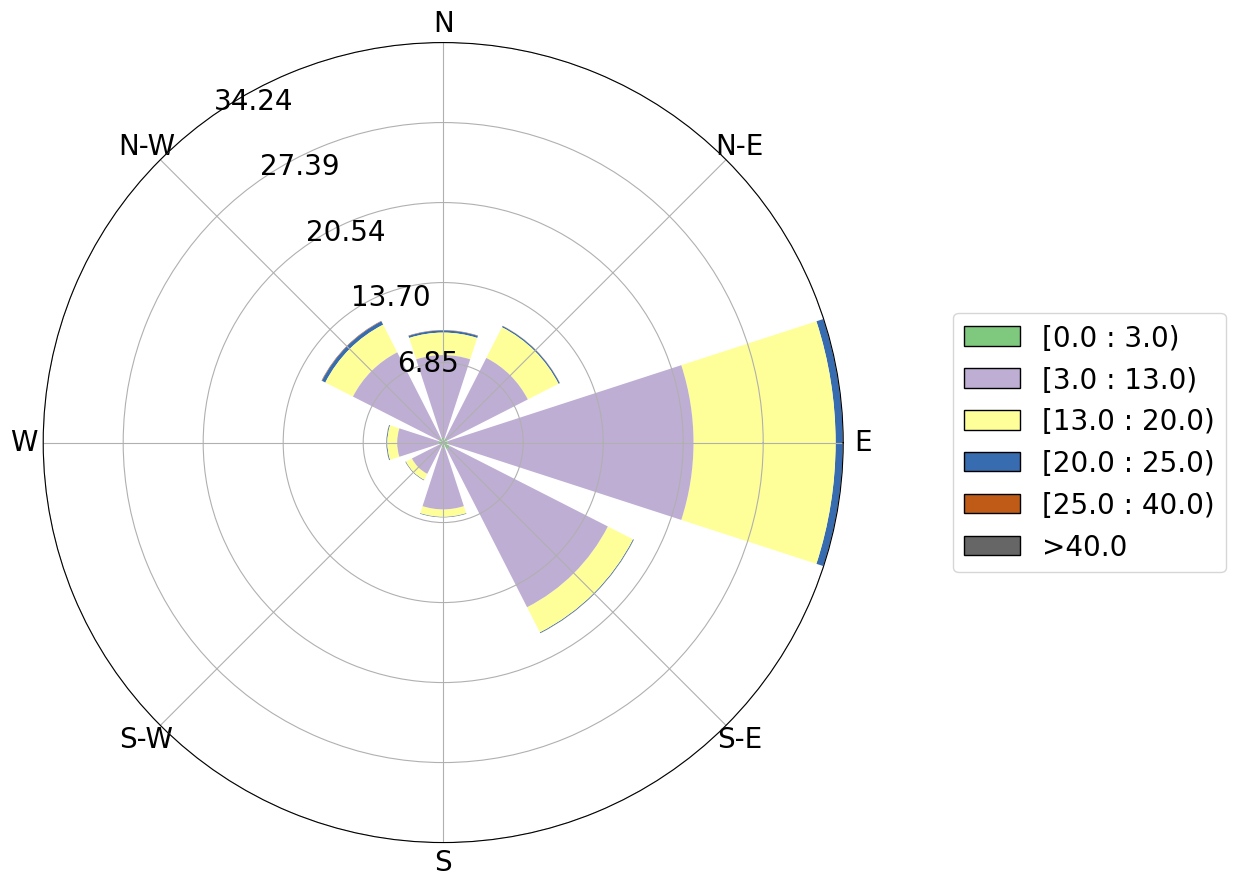

In [9]:
# Criar uma figura e adicionar os eixos para a rosa-dos-ventos
figura = plt.figure(figsize=(12, 8))
rict_rectangle = [0, 0, 1, 1]
ax = WindroseAxes(figura, rict_rectangle)
figura.add_axes(ax)

# Definir os dados de direção e magnitude do vento
direcao = Dataset[DirectionName].copy()  # Graus de direção do vento
magnetude = Dataset[WindName].copy()  # Magnitude do vento

# Definir algumas configurações opcionais para o gráfico
displayed = True
divisores_dados = [0,3,13,20,25,40] # bins (array 1D ou inteiro, opcional) – número de bins ou uma variável de sequência de bins. Se não definido, bins=6 entre min(var) e max(var).
blowto = False # blowto (bool, opcional.) – se True, a rosa-dos-ventos será pi girada, para mostrar para onde o vento sopra (útil para rosa poluente).
divisores_angular = 8 # Se não definido, nsetores=16, cada setor será 360/16=22,5° e a tabela computada resultante será alinhada com os pontos cardeais.
palette_color = [
    'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r',
    'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r',
    'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r',
    'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r',
    'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r',
    'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r',
    'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r',
    'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r',
    'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r',
    'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn',
    'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r',
    'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone',
    'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool',
    'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r',
    'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth',
    'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar',
    'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg',
    'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot',
    'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r',
    'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r',
    'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket',
    'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10',
    'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain',
    'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted',
    'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'
]
map_color = plt.get_cmap("Accent")
opening = 0.8 # ( float, opcional ) – entre 0,0 e 1,0, para controlar o espaço entre cada setor (1,0 para nenhum espaço)

# Criar o gráfico da rosa-dos-ventos
#ax.contour(direcao, magnetude, normed=displayed, bins=divisores_dados, nsector=divisores_angular, cmap=map_color)#, opening=opening)
ax.bar(direcao, magnetude, normed=displayed, bins=divisores_dados, blowto=blowto, nsector=divisores_angular, cmap=map_color, opening=opening)

# Configurar os eixos e legendas
ax.tick_params(axis="both", which="major", labelsize=20)  # Configurar os tamanhos das fontes nos eixos
ax.legend(loc="center left", decimal_places=1, bbox_to_anchor=(1.12, 0.5), fontsize=20)  # Adicionar uma legenda ao gráfico
ax.set_rlabel_position(125)  # Posição dos rótulos dos eixos radiais
ax.yaxis.set_major_formatter(tkr.FormatStrFormatter("%2.2f"))  # Formato dos rótulos dos eixos radiais


# BUSCANDO RUMO QUE MÁXIMIZA O FATOR OPERAÇÃO (FO) - (MÉTODO EXATO)

RODE SOMENTE SE QUISER FILTRAR ALGUM AEROPORTO

In [10]:
DataFilesAuto_FILTRO = {
    CHOICE: DataFilesAuto[CHOICE]
}
DataFilesAuto_FILTRO

{'BRASILIA': {'Local': (-15.78944444, -47.92583332),
  'Altidude': '1160.96',
  'Dataset':                       DATA  DIRECAO   VENTO
  0      2000-05-07 12:00:00    126.0   7.387
  1      2000-05-07 13:00:00     75.0   9.137
  2      2000-05-07 14:00:00    117.0   9.526
  3      2000-05-07 15:00:00     58.0  11.275
  4      2000-05-07 16:00:00    167.0  11.275
  ...                    ...      ...     ...
  203626 2024-04-09 13:00:00     35.0   7.776
  203627 2024-04-09 14:00:00     35.0   9.720
  203628 2024-04-09 15:00:00     14.0   9.526
  203629 2024-04-09 16:00:00    223.0   9.526
  203630 2024-04-09 17:00:00     63.0   8.748
  
  [203631 rows x 3 columns],
  'Name File': 'dados_A001_H_2000-05-06_2024-04-09.csv',
  'Path File': 'INPUT\\dados_A001_H_2000-05-06_2024-04-09.csv'}}

In [11]:
# PERCORRENDO OS DADOS DE CADA AEROPORTOE OTIMIZANDO VALORES
FinalResult = []
aux_aeroporto = ""
DATA_RUN = DataFilesAuto_FILTRO if "DataFilesAuto_FILTRO" in locals() else DataFilesAuto
for aeroporto, ideaeroporto in zip(DATA_RUN, range(1,len(list(DATA_RUN.keys()))+1)):

    print(f"AEROPORTO: {aeroporto} - #/$".replace("#",str(ideaeroporto)).replace("$",str(len(list(DATA_RUN)))))
    
    # OBTENDO OS DADOS DO AEROPORTO
    Info = DATA_RUN[aeroporto]
    tabelao = Info["Dataset"].copy()
    local = Info["Local"]
    
    # FILTRANDO DADOS PARA ANALISES P/5, 10, 15 e 20 ANOS
    tabelao5    = tabelao[tabelao["DATA"]>=tabelao["DATA"].max()-timedelta(days=365*5 )].reset_index(drop=True).copy()
    tabelao10   = tabelao[tabelao["DATA"]>=tabelao["DATA"].max()-timedelta(days=365*10)].reset_index(drop=True).copy()
    tabelao15   = tabelao[tabelao["DATA"]>=tabelao["DATA"].max()-timedelta(days=365*15)].reset_index(drop=True).copy()
    tabelao20   = tabelao[tabelao["DATA"]>=tabelao["DATA"].max()-timedelta(days=365*20)].reset_index(drop=True).copy()
    
    # OBTENDO A DECLINAÇÃO MAGNETICA
    if (aux_aeroporto != aeroporto) is True:
        aux_aeroporto = aeroporto 
        MagneticDeclination = round(GetMagneticDeclination(local[0], local[1], driver), DecimalPlaces)
    
    # DESENHANDO A ROSA DOS VENTOS
    if True:
        
        # IMAGEM EM BRANCO
        imagem_branca = np.zeros((Height_IMG, Width_IMG, 3), dtype=np.uint8)

        # Calculando as coordenadas do centro da imagem
        centro_x = int(Width_IMG  / 2)
        centro_y = int(Height_IMG / 2)

        maior = max(LIMITES)
        menor = min(LIMITES)

        proporcao = ProportionWindRoseImg/maior
        comprimento = int(Width_IMG * (maior * proporcao))
        WidthRunway = 0
        for limite in LIMITES[::-1]:
            r = int(Width_IMG * (limite * proporcao))
            if limite == LIMITES[-1]: cv.circle(imagem_branca, (centro_x, centro_y), r, (255, 255, 255), -1)
            cv.circle(imagem_branca, (centro_x, centro_y), r, (0, 0, 255), 2)
            if limite == WindRunwayLimite: WidthRunway = r

        # Desenhando as linhas radiais para cada direção
        graus_rumo = calcular_setores(RoseWind, SectorNames[RoseWind])
        for name, angulo in graus_rumo.items(): DrawRadialLine(imagem_branca, (centro_x, centro_y), comprimento, angulo[0], (0, 0, 0), 2)

    # IDENTIFICANDO CADA AREA DA ROSA DOS VENTOS COM UMA COR ESPECIFICA
    if True:
        imagem_AREA = imagem_branca.copy()

        # Crie uma máscara para identificar as regiões brancas na imagem
        branco_baixo = np.array([255, 255, 255])
        branco_alto = np.array([255, 255, 255])
        mascara_branco = cv.inRange(imagem_AREA, branco_baixo, branco_alto)

        # Encontre os contornos na imagem mascarada
        contornos, _ = cv.findContours(mascara_branco, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

        # REALIZANDO O AGRUPAMENTO DAS AREAS
        rotulos_clusters, grupos, center_grups = Agroup(contornos)

        # Criar uma nova imagem para desenhar os contornos coloridos
        cores_grupos = GenerateUniqueGrayColors(len(LIMITES)*RoseWind)

        # SALVANDO INFORMAÇÕES SOBRE AS AREAS
        dict_area_info = {}

        # Para cada grupo de contornos, criar uma paleta de cores única
        contagem = 0
        
        # ORDENANDO DOS MAIORES GRUPOS PARA OS MENORES 
        grupos = sorted(grupos, key=lambda x: cv.contourArea(x[0]), reverse=True)
        id_grupo = 1
        for grupo, limite in zip(grupos, LIMITES[::-1]):
            # Gerar cores únicas para o grupo com base no número de contornos
            parcial = {}
            for contorno in grupo:
                cor = cores_grupos[contagem]  # Selecionar uma cor única da paleta para cada área dentro do grupo
                cv.drawContours(imagem_AREA, [contorno], -1, cor, thickness=cv.FILLED)  # Preencher o contorno com a cor
        
                # # CALCULANDO ANGULO DO CENTRO PARA AREA PARA IDENTIFICAR O RUMO
                p1 = BaricentroArea(contorno)
                p2 = centro_x, centro_y
                angulo = CalculateAzimuth(p1, p2)
                rumo = ""
                for name, angulos in graus_rumo.items():
                    maior_ = max(angulos)
                    menor_ = min(angulos)
                    if angulo >= menor_ and angulo <= maior_:
                        rumo = name
                    elif angulo <= menor_ and angulo <= maior_:
                        rumo = "N"

                contagem+=1
                
                parcial[rumo] = {
                    # "CONTORNO": contorno, 
                    "AREA": cv.contourArea(contorno), 
                    "COR": cor,
                    "LIMITE": limite
                }
            dict_area_info[id_grupo] = parcial
            id_grupo+=1
    
    # DESENHANDO O RETANGULO DA PISTA E RECORTANDO
    if True:

        # Definindo as dimensões do retângulo
        largura_retangulo = WidthRunway * 2
        altura_retangulo = comprimento * 2

        # Calculando os vértices do retângulo
        vertices = np.array([
            [centro_x - largura_retangulo / 2, centro_y - altura_retangulo / 2],
            [centro_x + largura_retangulo / 2, centro_y - altura_retangulo / 2],
            [centro_x + largura_retangulo / 2, centro_y + altura_retangulo / 2],
            [centro_x - largura_retangulo / 2, centro_y + altura_retangulo / 2]
        ], dtype=np.float32)

        # CRIANDO PONTO DE RESTAURAÇÃO DA IMG SEM DESENHO
        imagem_AREA_BK = imagem_AREA.copy()
        
        # PERCORRENDO DADOS
        DFS = {
            ">=5"   :tabelao5,
            ">=10"  :tabelao10,
            ">=15"  :tabelao15,
            ">=20"  :tabelao20
        }
        dict_final = {}
        dict_pacial = {}
        for Name in DFS:
            Dataset = DFS[Name]
            
            # LIMPANDO A PASTA DE IMGS SE FOR FAZER UM NOVO VIDEO
            if MakeVideo is True: ClearFolder(FolderImages)
            
            # SE EXISTIR DADOS PROSSIGA
            if len(Dataset) > 0:
            
                # CONTABILIZANDO VENTOS PARA CADA DIRECAO EM PORCENTAGEM
                df_pct_ventos = Script1(Dataset[DirectionName], Dataset[WindName], SectorNames[RoseWind], LIMITES)

                # DADOS PARA SALVAR A OTIMIZAÇÃO
                FU_FINAL = 0
                FU_FINAL_MAXIMO = 0
                FU_FINAL_GRAU = 0
                
                # ANGULANDO A PISTA PARA BUSCAR OTIMIZAR O FU
                for grau in range(0, MaxSpinRoseWind+1):
                    
                    # RESTAURANDO BK DA IMG SEM DESENHOS
                    imagem_AREA = imagem_AREA_BK.copy()
                    
                    # Criando uma matriz de rotação de 30 graus em torno do centro da imagem
                    theta = np.radians(grau)
                    rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
                    centro_retangulo = np.array([centro_x, centro_y])
                    vertices_rotacionados = np.dot(vertices - centro_retangulo, rot_mat.T) + centro_retangulo

                    # Desenhando o retângulo na imagem
                    cv.polylines(
                        imagem_AREA, 
                        [vertices_rotacionados.astype(np.int32)], 
                        isClosed=True, 
                        color=ColorRunWay, 
                        thickness=2
                    )
                    
                    # Crie uma máscara para identificar as regiões brancas na imagem
                    mascara = cv.inRange(
                        imagem_AREA, 
                        ColorRunWay, 
                        ColorRunWay
                    )

                    # Encontre os contornos na imagem mascarada
                    contornos, _ = cv.findContours(
                        mascara, 
                        cv.RETR_EXTERNAL, 
                        cv.CHAIN_APPROX_NONE
                    )
                    
                    # PINTANDO A PISTA COMPLETA DE UMA COR PARA IDENTIFICAR POR MASCARA E RECORTAR
                    imagem_AREA2 = imagem_AREA_BK.copy()
                    cv.drawContours(
                        imagem_AREA2, 
                        contornos, 
                        -1, 
                        ColorRunWay,
                        thickness=cv.FILLED
                    )
                    
                    # Aplicar a máscara na imagem original
                    mascara_recorte = cv.inRange(
                        imagem_AREA2, 
                        ColorRunWay,
                        ColorRunWay
                    )
                    pista_recortada = cv.bitwise_and(
                        imagem_AREA, 
                        imagem_AREA,
                        mask=mascara_recorte
                    )
                    
                    # PUXANDO TABELA DE VENTOS DO SCRIPT 1 E RENOMEANDO AS ValoresS 
                    # PARA UMA CONSULTA MAIS FACILITADA
                    df_pct_ventos_cp = df_pct_ventos.copy()
                    df_pct_ventos_cp.columns = LIMITES + ["40+"]

                    # FIXANDO A PISTA DE MAIOR THETA
                    if FU_FINAL > FU_FINAL_MAXIMO:
                        FU_FINAL_MAXIMO = FU_FINAL
                        FU_FINAL_GRAU = grau
                    
                    # SE EXISTIR UM FU DESENHE 
                    if FU_FINAL_MAXIMO > 0:
                                
                        # Criando uma matriz de rotação de 30 graus em torno do centro da imagem
                        theta = np.radians(FU_FINAL_GRAU)
                        rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
                        centro_retangulo = np.array([centro_x, centro_y])
                        vertices_rotacionados = np.dot(vertices - centro_retangulo, rot_mat.T) + centro_retangulo
                        
                        # Desenhando o retângulo na imagem
                        cv.polylines(
                            imagem_AREA, 
                            [vertices_rotacionados.astype(np.int32)], 
                            isClosed=True, 
                            color=ColorBestRunWay, 
                            thickness=2
                        )

                        # DESENHANDO REFERENCIA DOS DADOS
                        DrawReferenceRUNWAY(
                            imagem_AREA, 
                            (centro_x, centro_y), 
                            comprimento, 
                            FU_FINAL_GRAU, 
                            (255, 165, 0), 
                            25
                        )
                    
                    # ANALISANDO O FATOR DE ULILIZAÇÃO DA PISTA ATUAL
                    FU_FINAL = 0
                    for id_grupo in dict_area_info:
                        grupo = dict_area_info[id_grupo]
                        for rumo in grupo:
                            Info = grupo[rumo]
                            cor_grupo = Info["COR"]
                            limite = Info["LIMITE"]
                            
                            # Crie uma máscara para identificar as regiões brancas na imagem
                            mascara = cv.inRange(
                                pista_recortada.copy(), 
                                cor_grupo, 
                                cor_grupo
                            )
                            
                            # Encontre os contornos na imagem mascarada
                            contorno, _ = cv.findContours(
                                mascara, 
                                cv.RETR_EXTERNAL, 
                                cv.CHAIN_APPROX_NONE
                            )
                            contorno = list(contorno)
                            
                            # NEM TODA AERA ESTA DENTRO DA PISTA LOGO 
                            if len(contorno) > 0:  area_dentro_PPD = cv.contourArea(contorno[0])
                            # CASO NÃO ESTIVER SETE ZERO
                            else: area_dentro_PPD = 0
                            
                            # FAZENDO A FRAÇÃO DOS VENTROS DENTRO DA PISTA
                            fracao_dentro = ( area_dentro_PPD / Info["AREA"] ) * df_pct_ventos_cp.loc[rumo][limite]
                            
                            FU_FINAL = FU_FINAL + fracao_dentro
                    FU_FINAL = round(FU_FINAL, DecimalPlaces)
                    
                    # INFORMAÇÕES SOBRE A PISTA ATUAL
                    texts = [
                        f'DIRECTION NOW',
                        f'FO: {FU_FINAL}%',
                        f'RUMO: {grau}',
                        f'MAGNETIC DECLINATION: {MagneticDeclination}',
                        f'RUNWAY ORIENTATION: {HeadboardRunway(round(grau - MagneticDeclination, DecimalPlaces))}',
                        f'CROSS WIND: {round(100 - FU_FINAL, DecimalPlaces)}%',
                        
                    ]
                    for text, id in zip(texts, list(range(1, len(texts)+1))):
                        cv.putText(imagem_AREA, text, (StartLegendRight, HeightEspaceLegend*id), Fonte, FonteSize, ColorRunWay, FonteThickness, cv.LINE_AA)

                    # INFORMAÇÕES SOBRE A MELHOR PISTA
                    if FU_FINAL_MAXIMO > 0:
                        
                        texts = [
                            f'BEST DIRECTION',
                            f'FO: {FU_FINAL_MAXIMO}%',
                            f'RUMO: {FU_FINAL_GRAU}',
                            f'MAGNETIC DECLINATION: {MagneticDeclination}',
                            f'RUNWAY ORIENTATION: {HeadboardRunway(round(FU_FINAL_GRAU - MagneticDeclination, DecimalPlaces))}',
                            f'CROSS WIND: {round(100 - FU_FINAL_MAXIMO, DecimalPlaces)}%',
                        ]
                        for text, id in zip(texts, list(range(1, len(texts)+1))):
                            cv.putText(imagem_AREA, text, (StartLegendLeft, HeightEspaceLegend*id), Fonte, FonteSize, ColorBestRunWay, FonteThickness, cv.LINE_AA)

                    # DESENHANDO PARTE INFERIOR DA IMAGEM
                    texts = [
                        f'Airport: {aeroporto}',
                        f'Lat: {local[0]} / Lon: {local[1]}'
                    ]
                    texts.reverse()
                    for text, id in zip(texts, list(range(1, len(texts)+1))):
                        cv.putText(imagem_AREA, text, (StartLegendLeft, Height_IMG-HeightEspaceLegend*id), Fonte, FonteSize, ColorLegend_BottomLeft, FonteThickness, cv.LINE_AA)

                    # DESENHANDO A REFERENCIA DA PISTA
                    DrawReferenceRUNWAY(imagem_AREA, (centro_x, centro_y), comprimento, grau, ColorPointRef, PointSizeRef)
                    
                    # SE DESEJAR CRIAR UM VIDEO DA SIMULAÇÃO SALVE AS IMGS
                    if MakeVideo is True:
                        
                        # SALVANDO IMAGEM PARA O VIDEO FINAL
                        cv.imwrite(os.path.join(FolderImages, f"IMG{grau}.jpg"), imagem_AREA)

                dict_pacial[Name] = {
                    "FO": FU_FINAL_MAXIMO,
                    "RUMO": FU_FINAL_GRAU,
                    "CROSS WIND": round(100 - FU_FINAL_MAXIMO, DecimalPlaces)
                }
                
                # SE ATIVADO CRIA O VIDEO
                numbers = "".join([row for row in Name if row.isdigit()])
                if MakeVideo is True: 
                    path_save = caminho_saida_video.format(aeroporto, numbers)
                    if os.path.exists(os.path.dirname(path_save)) is False:
                        os.makedirs(os.path.dirname(path_save))
                    CreateVideo(FolderImages, path_save)
                    # Carrega o vídeo
                    clip = VideoFileClip(path_save)
                    # Converte para GIF e salva
                    clip.speedx(SpeedGIF).write_gif(path_save.replace(".mp4",".gif"), program="ffmpeg", fps=5, opt="OptimizeTransparency", fuzz=1)

        dict_final[aeroporto] = dict_pacial
        FinalResult.append(dict_final)
        if SaveFinalEsult:
            with open("FinalResult.json", "w", encoding="UTF-8") as file:
                json.dump(FinalResult, file)


AEROPORTO: BRASILIA - 1/1
MoviePy - Building file  c:\Users\johnh\OneDrive\Desktop\VIVIANE\HORO\2-OUTPUT\Movies\BRASILIA\RunwayOrientation-5.gif
MoviePy - - Generating GIF frames.


MoviePy - - File ready: c:\Users\johnh\OneDrive\Desktop\VIVIANE\HORO\2-OUTPUT\Movies\BRASILIA\RunwayOrientation-5.gif.
MoviePy - Building file  c:\Users\johnh\OneDrive\Desktop\VIVIANE\HORO\2-OUTPUT\Movies\BRASILIA\RunwayOrientation-10.gif
MoviePy - - Generating GIF frames.


MoviePy - - File ready: c:\Users\johnh\OneDrive\Desktop\VIVIANE\HORO\2-OUTPUT\Movies\BRASILIA\RunwayOrientation-10.gif.
MoviePy - Building file  c:\Users\johnh\OneDrive\Desktop\VIVIANE\HORO\2-OUTPUT\Movies\BRASILIA\RunwayOrientation-15.gif
MoviePy - - Generating GIF frames.


MoviePy - - File ready: c:\Users\johnh\OneDrive\Desktop\VIVIANE\HORO\2-OUTPUT\Movies\BRASILIA\RunwayOrientation-15.gif.
MoviePy - Building file  c:\Users\johnh\OneDrive\Desktop\VIVIANE\HORO\2-OUTPUT\Movies\BRASILIA\RunwayOrientation-20.gif
MoviePy - - Generating GIF frames.


MoviePy - - File ready: c:\Users\johnh\OneDrive\Desktop\VIVIANE\HORO\2-OUTPUT\Movies\BRASILIA\RunwayOrientation-20.gif.
